In [32]:
#Kütüphaneleri içe aktarıyoruz.
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error,roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [33]:
#Veriyi yüklüyoruz.
df = pd.read_csv("/content/advertising.csv")

In [34]:
#Veriye genel bakış yapıyoruz.
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(5))
    print("##################### Tail #####################")
    print(dataframe.tail(5))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.25, 0.50, 0.75, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(200, 4)
##################### Types #####################
TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object
##################### Head #####################
       TV  radio  newspaper  sales
0 230.100 37.800     69.200 22.100
1  44.500 39.300     45.100 10.400
2  17.200 45.900     69.300  9.300
3 151.500 41.300     58.500 18.500
4 180.800 10.800     58.400 12.900
##################### Tail #####################
         TV  radio  newspaper  sales
195  38.200  3.700     13.800  7.600
196  94.200  4.900      8.100  9.700
197 177.000  9.300      6.400 12.800
198 283.600 42.000     66.200 25.500
199 232.100  8.600      8.700 13.400
##################### NA #####################
TV           0
radio        0
newspaper    0
sales        0
dtype: int64
##################### Quantiles #####################
            count    mean    std   min    0%    25%     50%     75%     99%    100%     m

In [11]:
#Değişken türlerini belirliyoruz.
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                 dataframe[col].dtypes == "O"]

  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" ]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols,num_but_cat

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 200
Variables: 4
cat_cols: 0
num_cols: 4
cat_but_car: 0
num_but_cat: 0


count   200.000
mean    147.042
std      85.854
min       0.700
5%       13.195
10%      24.880
20%      59.180
30%      86.750
40%     119.000
50%     149.750
60%     186.060
70%     210.730
80%     228.540
90%     261.440
95%     280.735
99%     292.907
max     296.400
Name: TV, dtype: float64


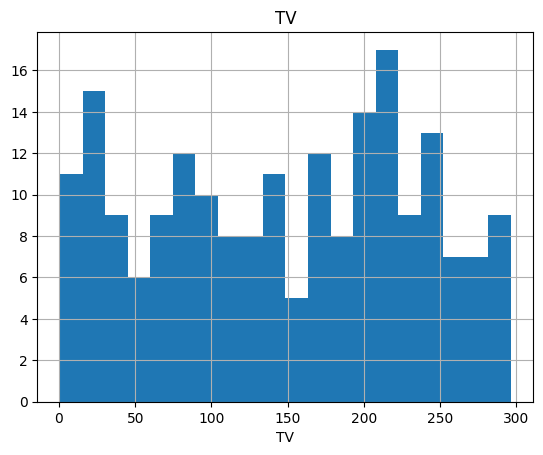

count   200.000
mean     23.264
std      14.847
min       0.000
5%        1.995
10%       3.400
20%       7.680
30%      11.940
40%      17.120
50%      22.900
60%      27.860
70%      33.500
80%      38.920
90%      43.520
95%      46.810
99%      49.400
max      49.600
Name: radio, dtype: float64


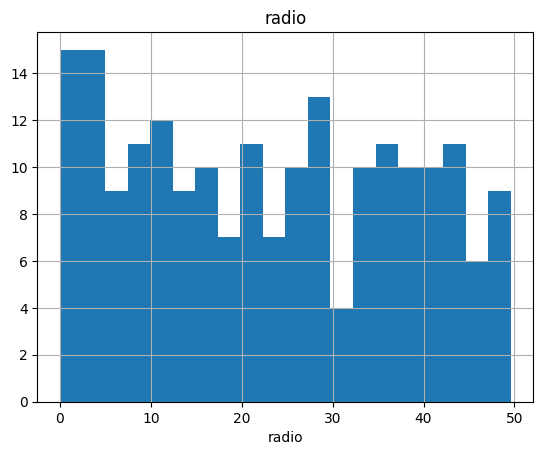

count   200.000
mean     30.554
std      21.779
min       0.300
5%        3.600
10%       5.990
20%       9.380
30%      15.970
40%      21.320
50%      25.750
60%      32.700
70%      39.110
80%      49.640
90%      59.070
95%      71.825
99%      89.515
max     114.000
Name: newspaper, dtype: float64


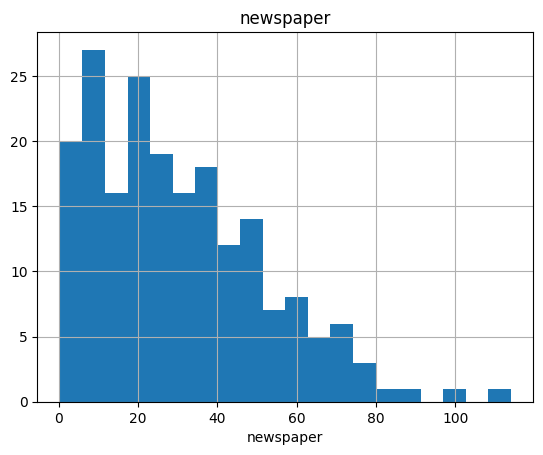

count   200.000
mean     14.023
std       5.217
min       1.600
5%        6.600
10%       7.960
20%       9.700
30%      10.870
40%      11.800
50%      12.900
60%      14.800
70%      16.600
80%      18.920
90%      21.710
95%      23.800
99%      25.507
max      27.000
Name: sales, dtype: float64


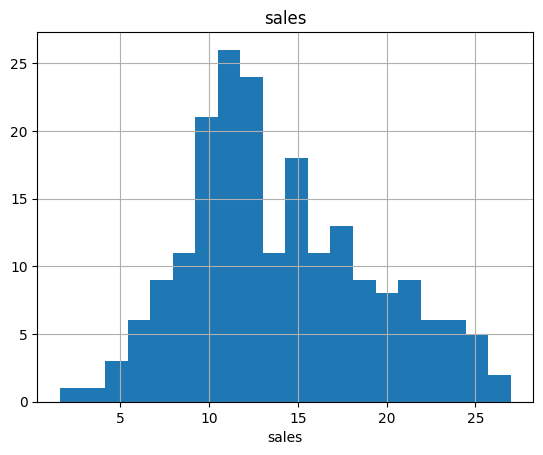

In [12]:
#Numerik değişken analizi
def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  if plot:
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.title(numerical_col)
    plt.show(block=True)

for col in num_cols:
  num_summary(df, col, plot=True)

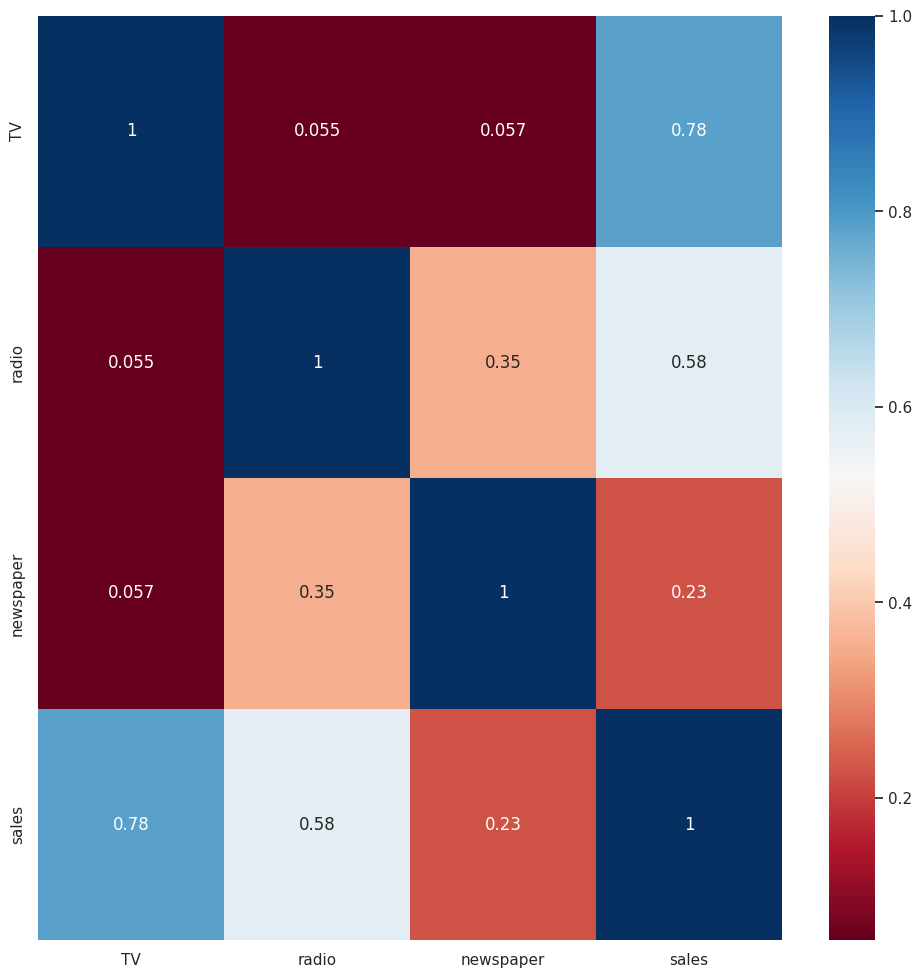

In [14]:
#Korelasyon analizi
corr = df[num_cols].corr()

sns.set(rc={"figure.figsize": (12,12)})
sns.heatmap(corr, annot=True, cmap="RdBu")
plt.show(block=True)

In [15]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5*interquantile_range
  low_limit = quartile1 - 1.5*interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

for col in num_cols:
    print(col, check_outlier(df, col))

TV False
radio False
newspaper True
sales False


In [17]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

TV False
radio False
newspaper False
sales False


In [18]:
#Eksik değer kontrolü
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0]*100)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")

  if na_name:
      return na_columns

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [19]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,TV,radio,newspaper,sales
0,0.970,0.982,1.824,1.552
1,-1.197,1.083,0.691,-0.696
2,-1.516,1.528,1.829,-0.907
3,0.052,1.218,1.321,0.860
4,0.394,-0.842,1.316,-0.216


In [22]:
dff = df.copy()

In [26]:
y = dff["sales"]
X = dff.drop(["sales"], axis = 1)

models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name})")

RMSE: 0.325 (LR)
RMSE: 0.2212 (KNN)
RMSE: 0.2144 (CART)
RMSE: 0.1418 (RF)
RMSE: 0.1317 (GBM)
RMSE: 0.1478 (XGBoost)
RMSE: 0.1321 (CatBoost)


In [27]:
y = df["sales"]
X = df.drop("sales", axis=1)

gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=10, n_jobs=-1, verbose=True).fit(X, y)
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [28]:
rmse

0.10399327198883526